In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Célfüggvény: ezt fogjuk közelíteni egy "KAN-él" aktivációjával
def target_function(x):
    return np.sin(x) + x**2   # nyugodtan módosíthatod pl. np.sin(x) -re

# Tanításhoz használt x-tartomány
X_MIN, X_MAX = -3.0, 3.0

# Hány B-spline (háztető) bázis legyen
NUM_BASIS = 15

# Tanítópontok száma
NUM_TRAIN = 256

# ====== Háztető (linear B-spline) bázis ======
def make_grid(x_min, x_max, num_basis):
    """
    Egyenletes rácspontokat készítünk, amelyeken
    a B-spline bázisfüggvények csúcsa lesz.
    """
    return np.linspace(x_min, x_max, num_basis)

def hat_basis_matrix(x, grid):
    """
    Triangular (hat) bázis: ez lineáris B-spline ekvivalens.
    Minden B_i(x) egy háromszög alakú függvény:
    - csúcs a grid[i] pontban (érték = 1)
    - 0-ra megy le a szomszédos rácspontokon
    - azon kívül 0
    Visszaad egy (len(x), num_basis) mátrixot.
    """
    x = np.asarray(x)
    num_basis = len(grid)
    Phi = np.zeros((x.shape[0], num_basis))

    # végigmegyünk az összes bázisfüggvényen
    for i in range(num_basis):
        center = grid[i]
        # bal és jobb szomszéd (szélénél kicsit trükközünk)
        if i == 0:
            left = grid[0]
        else:
            left = grid[i-1]
        if i == num_basis-1:
            right = grid[-1]
        else:
            right = grid[i+1]

        # bal oldali felfutó szakasz
        mask_left = (x >= left) & (x <= center)
        Phi[mask_left, i] = (x[mask_left] - left) / (center - left + 1e-12)

        # jobb oldali lefutó szakasz
        mask_right = (x > center) & (x <= right)
        Phi[mask_right, i] = (right - x[mask_right]) / (right - center + 1e-12)

    return Phi

# Rács a B-spline bázisnak
grid = make_grid(X_MIN, X_MAX, NUM_BASIS)


In [76]:
# ====== Modellparaméterek (globális változók) ======

# Bázisfüggvény: b(x) = SiLU(x)
def base_activation(x):
    return x / (1.0 + np.exp(-x))

# Paraméterek: w_b, w_s, c (B-spline koefficiensek)
w_b = None
w_s = None
c = None

def init_params():
    """
    Paraméterek inicializálása.
    w_b: Xavier-szerű
    w_s: 1
    c: kis random értékek (spline kezdetben ~0)
    """
    global w_b, w_s, c
    rng = np.random.default_rng(0)
    w_b = rng.normal(loc=0.0, scale=np.sqrt(2.0 / 1.0))  # 1D bemenet
    w_s = 1.0
    c = rng.normal(loc=0.0, scale=0.01, size=NUM_BASIS)

init_params()

def kan_edge_activation(x):
    """
    Egyetlen KAN-él aktivációja:
        φ(x) = w_b * b(x) + w_s * spline(x)
    spline(x) = sum_i c_i B_i(x)
    """
    x = np.asarray(x)
    Phi = hat_basis_matrix(x, grid)      # (N, num_basis)
    spline_part = Phi @ c               # (N,)
    base_part = base_activation(x)      # (N,)
    return w_b * base_part + w_s * spline_part


In [2]:
def train_step(num_steps=10, lr=1e-2, verbose=True):
    """
    Lefuttat num_steps darab gradient descent lépést a globális
    w_b, w_s, c paramétereken.
    """
    global w_b, w_s, c

    rng = np.random.default_rng()
    for step in range(num_steps):
        # mintavételezünk tanítópontokat
        x_train = rng.uniform(X_MIN, X_MAX, size=NUM_TRAIN)
        y_true = target_function(x_train)

        # előrehaladás
        Phi = hat_basis_matrix(x_train, grid)    # (N, K)
        spline_part = Phi @ c                    # (N,)
        base_part = base_activation(x_train)     # (N,)
        y_pred = w_b * base_part + w_s * spline_part

        # veszteség: MSE
        diff = y_pred - y_true
        loss = np.mean(diff**2)

        # gradiens a kimenetre: dL/dy_pred
        grad_y = 2.0 * diff / x_train.shape[0]   # (N,)

        # gradiens c-re:
        # y_pred = w_b * b(x) + w_s * Phi c
        # d y_pred / d c = w_s * Phi
        grad_c = w_s * (Phi.T @ grad_y)          # (K,)

        # gradiens w_s-re:
        grad_w_s = np.sum(spline_part * grad_y)  # skalár

        # gradiens w_b-re:
        grad_w_b = np.sum(base_part * grad_y)    # skalár

        # paraméterfrissítés
        c   -= lr * grad_c
        w_s -= lr * grad_w_s
        w_b -= lr * grad_w_b

    if verbose:
        print(f"Utolsó lépés loss = {loss:.6f}, w_b = {w_b:.3f}, w_s = {w_s:.3f}")


In [3]:
def plot_current(title_suffix=""):
    """
    Kirajzolja:
    - a célfüggvényt
    - a tanult aktivációs függvényt φ(x)
    - a spline részét külön is (csak szemléltetésre)
    - és a bázisfüggvényeket szürkével, hogy lásd, miből áll a spline
    """
    x_plot = np.linspace(X_MIN, X_MAX, 400)
    y_true = target_function(x_plot)
    y_pred = kan_edge_activation(x_plot)

    # spline rész külön
    Phi = hat_basis_matrix(x_plot, grid)
    spline_only = Phi @ c

    plt.figure(figsize=(8, 5))

    # bázisfüggvények (kis átlátszósággal)
    for i in range(NUM_BASIS):
        plt.plot(x_plot, Phi[:, i], alpha=0.2, linewidth=1)

    # spline rész
    plt.plot(x_plot, spline_only, linestyle="--", label="spline rész (∑ c_i B_i(x))")

    # teljes aktiváció = w_b*b(x) + w_s*spline(x)
    plt.plot(x_plot, y_pred, label="KAN-aktiváció φ(x)")

    # célfüggvény
    plt.plot(x_plot, y_true, linestyle=":", label="célfüggvény")


In [4]:
plot_current("10 lépés után")

NameError: name 'kan_edge_activation' is not defined

Utolsó lépés loss = 0.000240, w_b = 2.345, w_s = 3.628


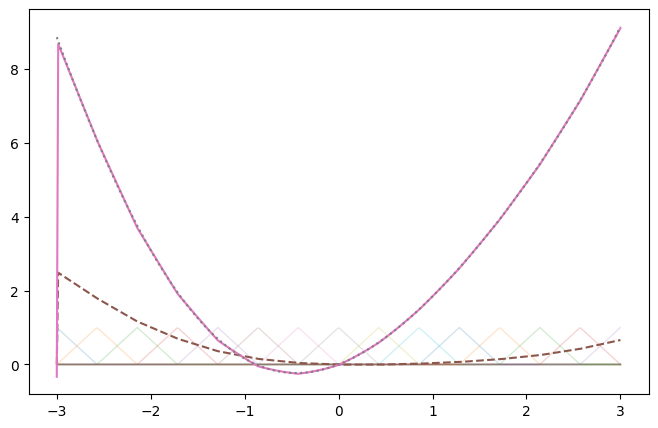

In [80]:
train_step(1000)
plot_current("20 lépés után")

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [6]:
# Intervallum és bázisok
X_MIN, X_MAX = -3, 3
NUM_BASIS = 6
grid = np.linspace(X_MIN, X_MAX, NUM_BASIS)

def hat_basis_matrix(x):
    x = np.asarray(x)
    Phi = np.zeros((len(x), NUM_BASIS))
    for i in range(NUM_BASIS):
        c = grid[i]
        l = grid[i-1] if i>0 else grid[i]
        r = grid[i+1] if i<NUM_BASIS-1 else grid[i]
        left = (x>=l)&(x<=c)
        right = (x>c)&(x<=r)
        Phi[left, i]  = (x[left]-l)/(c-l+1e-9)
        Phi[right, i] = (r-x[right])/(r-c+1e-9)
    return Phi


In [7]:
# Célfüggvény
def target(x):
    return np.sin(x) + 0.5*x

# Tanulható paraméterek (kezdetben kicsik)
c = np.random.randn(NUM_BASIS) * 0.1

def spline(x):
    Phi = hat_basis_matrix(x)
    return Phi @ c


In [8]:
def train_step(lr=0.05, batch=128):
    global c
    # mintavétel
    x = np.random.uniform(X_MIN, X_MAX, batch)
    y = target(x)

    Phi = hat_basis_matrix(x)
    y_pred = Phi @ c

    diff = y_pred - y
    loss = np.mean(diff**2)

    # gradiens (dL/dc = Phi^T * diff)
    grad_c = Phi.T @ (2*diff/batch)

    c -= lr * grad_c
    return loss


In [9]:
def plot_spline():
    xs = np.linspace(X_MIN, X_MAX, 400)
    Phi = hat_basis_matrix(xs)

    plt.figure(figsize=(10,5))

    # bázisfüggvények kirajzolása
    for i in range(NUM_BASIS):
        plt.plot(xs, Phi[:,i], "-", alpha=0.3)

    # tanult spline
    plt.plot(xs, Phi @ c, "r", linewidth=2, label="tanult spline")

    # célfüggvény
    plt.plot(xs, target(xs), "k--", label="célfüggvény")

    # súlyok megjelenítése kis téglalapokként
    for i in range(NUM_BASIS):
        plt.text(grid[i], 0.1, f"{c[i]:.2f}", color="teal")

    plt.title("Spline tanulása – bázisfüggvények + tanult spline")
    plt.legend()
    plt.grid(True)
    plt.show()


Iteráció: 99, loss: 0.1124


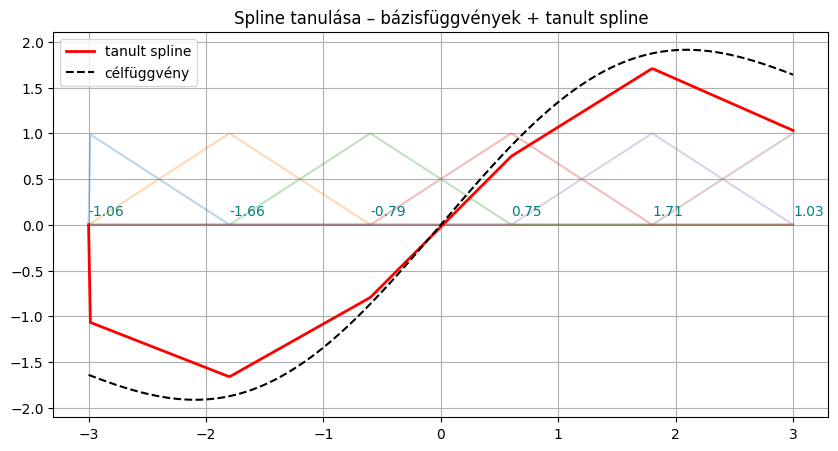

In [10]:
for epoch in range(100):
    loss = train_step()
    clear_output(wait=True)
    print(f"Iteráció: {epoch}, loss: {loss:.4f}")
    plot_spline()


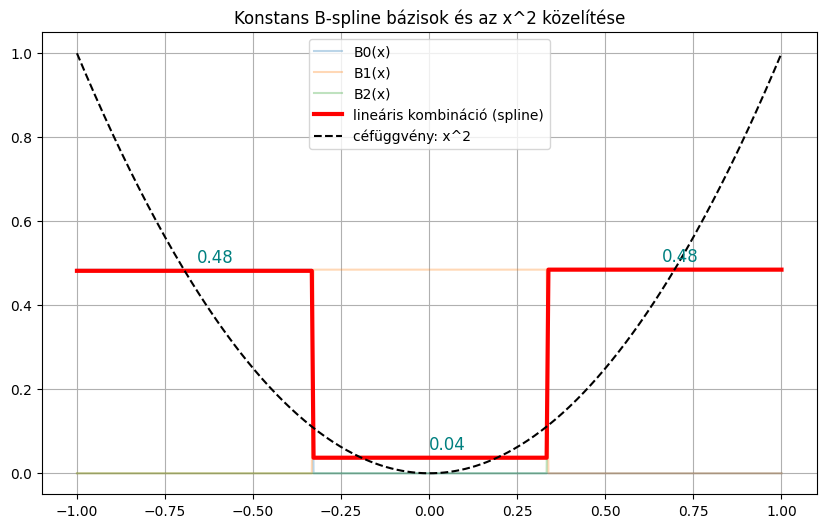

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# intervallum, 3 részre osztva
X_MIN, X_MAX = -1, 1
xs = np.linspace(X_MIN, X_MAX, 400)

# célfüggvény
def target(x):
    return x**2

# 3 konstans B-spline basis
def B0(x):
    return (x < -1/3).astype(float)

def B1(x):
    return ((x >= -1/3) & (x < 1/3)).astype(float)

def B2(x):
    return (x >= 1/3).astype(float)

basis = [B0(xs), B1(xs), B2(xs)]

# súlyok: a 3 intervallumon a célfüggvény átlaga
intervals = [xs[xs < -1/3], 
             xs[(xs>=-1/3)&(xs<1/3)], 
             xs[xs>=1/3]]

c = [target(iv).mean() for iv in intervals]

# spline érték
spline = c[0]*basis[0] + c[1]*basis[1] + c[2]*basis[2]

# ábra
plt.figure(figsize=(10,6))

# bázisfüggvények rajzolása (mint a videó jobb oldala)
for i, b in enumerate(basis):
    plt.plot(xs, b*max(c), alpha=0.3, label=f"B{i}(x)")

# spline görbe (mint a videó bal alsó rajza)
plt.plot(xs, spline, "r", linewidth=3, label="lineáris kombináció (spline)")

# célfüggvény
plt.plot(xs, target(xs), "k--", label="céfüggvény: x^2")

# súlyok kiírása
positions = [-0.66, 0.0, 0.66]
for pos, ci in zip(positions, c):
    plt.text(pos, ci+0.02, f"{ci:.2f}", fontsize=12, color="teal")

plt.title("Konstans B-spline bázisok és az x^2 közelítése")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# célfüggvény: tetszés szerint módosíthatod, pl. np.sin(x) is lehetne
def target(x):
    return x**2

X_MIN, X_MAX = -1.0, 1.0

def make_constant_basis(xs, num_bins):
    """
    Konstans B-spline (piecewise constant) bázis:
    B_i(x) = 1 az i-edik intervallumban, egyébként 0.
    """
    edges = np.linspace(X_MIN, X_MAX, num_bins + 1)
    basis = []
    for i in range(num_bins):
        left, right = edges[i], edges[i+1]
        bi = ((xs >= left) & (xs < right)).astype(float)
        # az utolsó intervallumnál vegyük bele a jobb szélét is
        if i == num_bins-1:
            bi = ((xs >= left) & (xs <= right)).astype(float)
        basis.append(bi)
    return edges, np.array(basis)  # shape: (num_bins, len(xs))


def plot_constant_spline(num_bins=3):
    """
    Interaktív függvény:
    - megrajzolja a konstans bázisfüggvényeket
    - kiszámítja az optimális c_i-ket (átlag a szakaszon)
    - megrajzolja a lépcsős spline-t és az x^2 célfüggvényt
    """
    xs = np.linspace(X_MIN, X_MAX, 400)
    ys = target(xs)

    edges, basis = make_constant_basis(xs, num_bins)

    # optimális súlyok: minden intervallumban a célfüggvény átlaga
    cs = []
    for i in range(num_bins):
        mask = basis[i] > 0
        if mask.sum() > 0:
            cs.append(ys[mask].mean())
        else:
            cs.append(0.0)
    cs = np.array(cs)

    # lépcsős spline: s(x) = sum c_i B_i(x)
    spline = (cs[:, None] * basis).sum(axis=0)

    # ábra: két subplot, balra bázisok, jobbra közelítés
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    # ----- 1. subplot: bázisfüggvények -----
    for i in range(num_bins):
        ax1.plot(xs, basis[i], linewidth=2, alpha=0.6)
        # kis címke az adott intervallum közepén
        mid = 0.5 * (edges[i] + edges[i+1])
        ax1.text(mid, 1.05, f"B{i}(x)", ha="center", va="bottom", fontsize=9)
    ax1.set_title(f"{num_bins} konstans B-spline bázis")
    ax1.set_ylim(-0.1, 1.3)
    ax1.grid(True)

    # ----- 2. subplot: lineáris kombináció + célfüggvény -----
    ax2.plot(xs, ys, "k--", label="célfüggvény: x²")
    ax2.plot(xs, spline, "r", linewidth=2, label="lépcsős spline (∑ c_i B_i(x))")

    # a horizontális szintek vizuális hangsúlyozása
    for i in range(num_bins):
        left, right = edges[i], edges[i+1]
        ax2.hlines(cs[i], left, right, colors="teal", linewidth=3)
        mid = 0.5 * (left + right)
        ax2.text(mid, cs[i] + 0.02*(ys.max()-ys.min()),
                 f"{cs[i]:.2f}", ha="center", color="teal", fontsize=9)

    ax2.set_title("Lineáris kombinációval kapott közelítés")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# interaktív slider: hány részre osztjuk az intervallumot
interact(plot_constant_spline,
         num_bins=IntSlider(value=3, min=1, max=10, step=1, description="bázisok száma"));


interactive(children=(IntSlider(value=3, description='bázisok száma', max=10, min=1), Output()), _dom_classes=…

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

# -------------------------------
# Célfüggvény: tetszőlegesen cserélhető
# -------------------------------
def target(x):
    # pl. sin(x) + x^2 is lehetne
    return x**2

# Intervallum
X_MIN, X_MAX = -1.0, 1.0

# -------------------------------
# Konstans B-spline (piecewise constant) bázis
# -------------------------------
def make_constant_basis(xs, num_bins):
    """
    Konstans B-spline bázis: B_i(x) = 1 az i-edik intervallumban, egyébként 0.
    Ugyanúgy 3 részre, 4 részre, ... osztjuk az intervallumot.
    """
    edges = np.linspace(X_MIN, X_MAX, num_bins + 1)
    basis = []
    for i in range(num_bins):
        left, right = edges[i], edges[i+1]
        bi = ((xs >= left) & (xs < right)).astype(float)
        # utolsó intervallumnál vegyük bele a jobb szélét is
        if i == num_bins - 1:
            bi = ((xs >= left) & (xs <= right)).astype(float)
        basis.append(bi)
    return edges, np.array(basis)  # (num_bins, len(xs))


# -------------------------------
# b(x) bázisfüggvény: SiLU
# -------------------------------
def base_activation(x):
    return x / (1.0 + np.exp(-x))


# -------------------------------
# Interaktív rajzoló függvény
# -------------------------------
def plot_kan_activation(num_bins=3, w_b=1.0, w_s=1.0):
    """
    Megrajzolja:
      - konstans B-spline bázisokat (bal subplot),
      - spline(x) = sum c_i B_i(x)-et,
      - b(x)-et,
      - φ(x) = w_b b(x) + w_s spline(x)-et,
      - és a célfüggvényt.
    A c_i-ket automatikusan úgy választjuk, hogy a spline közelítse a célfüggvényt
    (intervallumonként az átlag).
    """
    xs = np.linspace(X_MIN, X_MAX, 400)
    ys = target(xs)

    # bázisfüggvények
    edges, basis = make_constant_basis(xs, num_bins)   # basis.shape = (num_bins, len(xs))

    # optimális c_i: minden intervallumban a célfüggvény átlaga
    cs = []
    for i in range(num_bins):
        mask = basis[i] > 0
        if mask.sum() > 0:
            cs.append(ys[mask].mean())
        else:
            cs.append(0.0)
    cs = np.array(cs)

    # spline(x)
    spline = (cs[:, None] * basis).sum(axis=0)

    # b(x)
    b_vals = base_activation(xs)

    # teljes aktiváció: φ(x) = w_b b(x) + w_s spline(x)
    phi = w_b * b_vals + w_s * spline

    # ----------------------------------------------------
    # ÁBRÁK
    # ----------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4), sharex=True)

    # ---- 1. subplot: bázisfüggvények + c_i szintek ----
    for i in range(num_bins):
        ax1.plot(xs, basis[i], linewidth=2, alpha=0.6)
        mid = 0.5 * (edges[i] + edges[i+1])
        ax1.text(mid, 1.05, f"B{i}(x)", ha="center", va="bottom", fontsize=9)

    ax1.set_title(f"{num_bins} konstans B-spline bázis")
    ax1.set_ylim(-0.1, 1.3)
    ax1.grid(True)

    # ---- 2. subplot: közelítések és aktivációk ----
    # célfüggvény
    ax2.plot(xs, ys, "k--", label="célfüggvény: x²")

    # spline(x) mint lépcsős közelítés
    ax2.plot(xs, spline, "r", linewidth=2, label="spline(x) = ∑ c_i B_i(x)")

    # b(x) bázisfüggvény (SiLU)
    ax2.plot(xs, b_vals, "g--", label="b(x) = SiLU(x)")

    # teljes aktiváció
    ax2.plot(xs, phi, "b", linewidth=2, label="φ(x) = w_b b(x) + w_s spline(x)")

    # vízszintes szintek a cs_i-hez (mint a videóban)
    for i in range(num_bins):
        left, right = edges[i], edges[i+1]
        ax2.hlines(cs[i], left, right, colors="teal", linewidth=3)
        mid = 0.5 * (left + right)
        ax2.text(
            mid,
            cs[i] + 0.02 * (ys.max() - ys.min()),
            f"{cs[i]:.2f}",
            ha="center",
            color="teal",
            fontsize=9,
        )

    ax2.set_title(r"Teljes KAN-aktiváció: $\phi(x) = w_b b(x) + w_s \mathrm{spline}(x)$")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# -------------------------------
# Interaktív vezérlés
# -------------------------------
interact(
    plot_kan_activation,
    num_bins=IntSlider(value=3, min=1, max=10, step=1, description="B-spline-ok száma"),
    w_b=FloatSlider(value=1.0, min=-2.0, max=2.0, step=0.1, description="w_b"),
    w_s=FloatSlider(value=1.0, min=-2.0, max=2.0, step=0.1, description="w_s"),
);


interactive(children=(IntSlider(value=3, description='B-spline-ok száma', max=10, min=1), FloatSlider(value=1.…

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

In [15]:
def even_knots(n_internal, k0=0.0, kn=1.0):
    """
    Egyenletesen elosztott csomópontok [k0, kn] intervallumon.
    Visszaadja a knot-vektort (numpy array).
    """
    # n_internal belső csomópont + 2 szélső
    return np.linspace(k0, kn, n_internal + 2)


def bspline_basis(x, i, degree, knots):
    """
    Cox–de Boor rekurzióval kiszámolja az i-edik B-spline bázisfüggvény
    értékét a 'x' pontokon, adott fok (degree) és knot-vektor mellett.

    x      : numpy array
    i      : bázis indexe (lehet 0-tól len(knots)-2-degree-ig)
    degree : fok (0 = lépcső, 1 = lineáris, 2 = kvadratikus, 3 = kubikus, stb.)
    knots  : csomópontok (numpy array)
    """
    x = np.asarray(x)

    # 0. fok: indikátor az [k_i, k_{i+1}) intervallumra
    if degree == 0:
        left = knots[i]
        right = knots[i + 1]
        y = np.zeros_like(x, dtype=float)
        y[(x >= left) & (x < right)] = 1.0
        # utolsó intervallumnál vegyük bele a jobb szélt is
        if i + 1 == len(knots) - 1:
            y[x == right] = 1.0
        return y

    # magasabb fok: rekurzív definíció
    denom1 = knots[i + degree] - knots[i]
    denom2 = knots[i + degree + 1] - knots[i + 1]

    # w1, w2 súlyok (vigyázunk a 0 osztásokkal)
    if denom1 == 0:
        w1 = np.zeros_like(x, dtype=float)
    else:
        w1 = (x - knots[i]) / denom1

    if denom2 == 0:
        w2 = np.zeros_like(x, dtype=float)
    else:
        w2 = (knots[i + degree + 1] - x) / denom2

    y1 = bspline_basis(x, i,     degree - 1, knots)
    y2 = bspline_basis(x, i + 1, degree - 1, knots)

    return w1 * y1 + w2 * y2


interactive(children=(IntSlider(value=1, description='fok', max=3), IntSlider(value=4, description='belső knot…

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Text

def plot_spline_with_custom_coeffs(degree=1, n_internal=4,
                                   coeffs_str="0.4, 0.4, 2.5, 3.1, 1.4, 1.4, 1, 1, 1, 1, 1"):
    """
    - degree: B-spline fok (0=lépcső, 1=lineáris, 2=kvadratikus, 3=kubikus)
    - n_internal: belső csomópontok száma
    - coeffs_str: vesszővel elválasztott súlyok, pl. "0.4, 0.4, 2.5"
    """

    # csomópontok
    knots = even_knots(n_internal=n_internal, k0=0.0, kn=1.0)

    # x-rács
    x = np.linspace(knots[0], knots[-1], 400)

    # bázisok száma
    n_basis = len(knots) - degree - 1
    if n_basis <= 0:
        print("Túl nagy fok ehhez a knots-számhoz, csökkentsd a degree-t vagy növeld n_internal-t!")
        return

    # szövegmezőből súlyok beolvasása
    try:
        coeffs_list = [float(s.strip()) for s in coeffs_str.split(",") if s.strip() != ""]
    except ValueError:
        print("Nem tudtam float-tá alakítani a súlyok egy részét. Írj olyasmit, mint: 0.4, 2.5, 1.0")
        return

    if len(coeffs_list) == 0:
        print("Nem adtál meg súlyokat.")
        return

    # ha kevesebb súly van, mint bázis, kipótoljuk nullákkal
    if len(coeffs_list) < n_basis:
        coeffs_list = coeffs_list + [0.0] * (n_basis - len(coeffs_list))
    # ha több, levágjuk
    coeffs = np.array(coeffs_list[:n_basis])

    # bázisfüggvények
    basis_vals = []
    for i in range(n_basis):
        y = bspline_basis(x, i, degree, knots)
        basis_vals.append(y)
    basis_vals = np.array(basis_vals)  # (n_basis, len(x))

    # spline(x) = Σ a_i B_i(x)
    spline_vals = (coeffs[:, None] * basis_vals).sum(axis=0)

    # -------------- ÁBRA ----------------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    # B-spline bázisok
    for i in range(n_basis):
        ax1.plot(x, basis_vals[i], label=f"B{i}(x)")
    ax1.set_title(f"{degree}. fokú B-spline bázisok\n(n_internal = {n_internal}, n_basis = {n_basis})")
    ax1.set_xlabel("x")
    ax1.set_ylabel("B_i(x)")
    ax1.grid(True)
    ax1.legend(fontsize=8)

    # spline
    ax2.plot(x, spline_vals, "r", label="spline(x) = Σ a_i B_i(x)")
    ax2.set_title("Súlyozott B-spline kombináció")
    ax2.set_xlabel("x")
    ax2.set_ylabel("spline(x)")
    ax2.grid(True)

    # csomópontok jelölése
    for k in knots:
        ax2.axvline(k, linestyle=":", linewidth=0.7)

    # ==== ÚJ RÉSZ: súlyfeliratok a bázisok csúcsán ====

    ymin, ymax = ax2.get_ylim()
    dy = 0.03 * (ymax - ymin)  # kis függőleges eltolás

    for i in range(n_basis):
        Bi = basis_vals[i]            # i-edik B-spline értékei
        j_max = np.argmax(Bi)         # ahol a legnagyobb
        x_pos = x[j_max]
        y_pos = spline_vals[j_max]

        ax2.text(
            x_pos,
            y_pos + dy,
            rf"$a_{i}={coeffs[i]:.2f}$",
            ha="center",
            va="bottom",
            color="teal",
            fontsize=9,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )

    ax2.legend()
    plt.tight_layout()
    plt.show()


interact(
    plot_spline_with_custom_coeffs,
    degree=IntSlider(value=1, min=0, max=3, step=1, description="fok"),
    n_internal=IntSlider(value=4, min=1, max=10, step=1, description="belső knots"),
    coeffs_str=Text(
        value="0.4, 0.4, 2.5, 3.1, 1.4, 1.4, 1, 1, 1, 1, 1",
        description="súlyok (a_i):",
        continuous_update=False
    ),
);


interactive(children=(IntSlider(value=1, description='fok', max=3), IntSlider(value=4, description='belső knot…

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def even_knots(n_internal, k0=0.0, kn=1.0):
    """Egyenletes csomópontok [k0, kn] intervallumon."""
    return np.linspace(k0, kn, n_internal + 2)


def bspline_basis(x, i, degree, knots):
    """
    Cox–de Boor rekurzióval B-spline bázis.
    x: pontok (array)
    i: bázis index
    degree: fok (0,1,2,3,...)
    knots: csomópont-vektor
    """
    x = np.asarray(x)

    # 0. fok: indikátor [k_i, k_{i+1}) intervallumra
    if degree == 0:
        left = knots[i]
        right = knots[i + 1]
        y = np.zeros_like(x, dtype=float)
        y[(x >= left) & (x < right)] = 1.0
        if i + 1 == len(knots) - 1:
            y[x == right] = 1.0
        return y

    # magasabb fok: rekurzív
    denom1 = knots[i + degree] - knots[i]
    denom2 = knots[i + degree + 1] - knots[i + 1]

    if denom1 == 0:
        w1 = np.zeros_like(x, dtype=float)
    else:
        w1 = (x - knots[i]) / denom1

    if denom2 == 0:
        w2 = np.zeros_like(x, dtype=float)
    else:
        w2 = (knots[i + degree + 1] - x) / denom2

    y1 = bspline_basis(x, i,     degree - 1, knots)
    y2 = bspline_basis(x, i + 1, degree - 1, knots)

    return w1 * y1 + w2 * y2


In [18]:
# Céfüggvény – ezt nyugodtan átírhatod
def target(x):
    return np.sin(2 * np.pi * x) + 0.3 * x

# Tanítópontok
rng = np.random.default_rng(0)
x_train = np.linspace(0.0, 1.0, 200)
y_train = target(x_train)


In [19]:
def train_and_plot_by_basis(epochs=0, degree=3, n_basis_slider=4, lr=0.05):
    """
    epochs        : GD lépések száma
    degree        : B-spline fok
    n_basis_slider: HÁNY B-SPLINE legyen (ezt állítod csúszkával)
    lr            : learning rate
    """

    # belső csomópontok száma a kívánt bázisszámhoz
    n_internal = n_basis_slider + degree - 1

    # knots és valódi bázisok száma
    knots = even_knots(n_internal=n_internal, k0=0.0, kn=1.0)
    n_basis = len(knots) - degree - 1

    # biztonsági ellenőrzés
    if n_basis != n_basis_slider:
        print(f"Figyelem: elvárt n_basis={n_basis_slider}, de a konstrukció miatt n_basis={n_basis}.")
    if n_basis <= 0:
        print("Ehhez a fokhoz túl kevés a knot. Növeld a n_basis_slider-t vagy csökkentsd a degree-t!")
        return

    # Design-mátrix tanító adatokhoz
    B = np.zeros((len(x_train), n_basis))
    for i in range(n_basis):
        B[:, i] = bspline_basis(x_train, i, degree, knots)

    # Súlyok (kezdetben 0)
    a = np.zeros(n_basis)

    # Gradient descent
    for _ in range(epochs):
        y_pred = B @ a
        diff = y_pred - y_train
        grad = 2.0 / len(x_train) * (B.T @ diff)
        a -= lr * grad

    # Loss
    y_pred = B @ a
    loss = np.mean((y_pred - y_train) ** 2)
    print(f"MSE loss = {loss:.6f} (epochs={epochs}, degree={degree}, n_basis={n_basis})")

    # Kiértékelés sűrű rácson
    x_plot = np.linspace(0.0, 1.0, 400)
    y_true_plot = target(x_plot)

    B_plot = np.zeros((len(x_plot), n_basis))
    for i in range(n_basis):
        B_plot[:, i] = bspline_basis(x_plot, i, degree, knots)
    y_spline_plot = B_plot @ a

    # ---- ábra ----
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4), sharex=True)

    # 1) Bázisfüggvények
    for i in range(n_basis):
        ax1.plot(x_plot, B_plot[:, i])
    ax1.set_title(f"{degree}. fokú B-spline bázisok\n(n_basis={n_basis}, n_internal={n_internal})")
    ax1.set_xlabel("x")
    ax1.set_ylabel("B_i(x)")
    ax1.grid(True)

    # 2) Céfüggvény + spline + pontok
    ax2.scatter(x_train, y_train, s=10, alpha=0.4, label="tanítópontok")
    ax2.plot(x_plot, y_true_plot, "k--", label="céfüggvény")
    ax2.plot(x_plot, y_spline_plot, "r", label="spline közelítés")
    for k in knots:
        ax2.axvline(k, linestyle=":", linewidth=0.7)

    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_title(f"Gradient descent spline tanulás\nMSE = {loss:.4f}")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [20]:
from ipywidgets import interact, IntSlider, FloatSlider

interact(
    train_and_plot_by_basis,
    epochs=IntSlider(value=0, min=0, max=200, step=10, description="epochs"),
    degree=IntSlider(value=3, min=0, max=3, step=1, description="fok"),
    n_basis_slider=IntSlider(value=4, min=1, max=10, step=1, description="B-spline-ok száma"),
    lr=FloatSlider(value=0.05, min=0.005, max=0.1, step=0.005, description="lr"),
);

interactive(children=(IntSlider(value=0, description='epochs', max=200, step=10), IntSlider(value=3, descripti…

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def open_uniform_knots(degree, n_basis, a=0.0, b=1.0):
    """
    Open uniform B-spline knotvektor:
    - a bal szélen degree+1-szer ismételt 'a'
    - a jobb szélen degree+1-szer ismételt 'b'
    - közte egyenletes belső knotok (ha vannak)

    degree : fok (0,1,2,3,...)
    n_basis: B-spline bázisfüggvények száma
    [a,b]  : intervallum
    """
    # knotok száma: n_basis + degree + 1
    n_knots = n_basis + degree + 1
    knots = np.empty(n_knots)

    # bal szélső ismétlés
    knots[:degree+1] = a
    # jobb szélső ismétlés
    knots[-(degree+1):] = b

    # belső knotok (ha marad hely)
    if n_knots > 2*(degree+1):
        n_internal = n_knots - 2*(degree+1)
        # belső knotok egyenletesen [a,b]-n
        internal = np.linspace(a, b, n_internal+2)[1:-1]
        knots[degree+1:-degree-1] = internal

    return knots


In [22]:
def train_and_plot_by_basis(epochs=0, degree=3, n_basis_slider=4, lr=0.05):
    """
    epochs        : GD lépések száma
    degree        : B-spline fok
    n_basis_slider: B-spline bázisfüggvények száma
    lr            : learning rate
    """

    n_basis = n_basis_slider
    knots = open_uniform_knots(degree=degree, n_basis=n_basis, a=0.0, b=1.0)

    x = x_train
    y = y_train

    # Design-mátrix
    B = np.zeros((len(x), n_basis))
    for i in range(n_basis):
        B[:, i] = bspline_basis(x, i, degree, knots)

    # Súlyok (0-ról indul)
    a = np.zeros(n_basis)

    # Gradient descent
    for _ in range(epochs):
        y_pred = B @ a
        diff = y_pred - y
        grad = 2.0 / len(x) * (B.T @ diff)
        a -= lr * grad

    # végső loss
    y_pred = B @ a
    loss = np.mean((y_pred - y)**2)
    print(f"MSE loss = {loss:.6f} (epochs={epochs}, degree={degree}, n_basis={n_basis})")

    # kiértékelés tömör rácson
    x_plot = np.linspace(0.0, 1.0, 400)
    y_true_plot = target(x_plot)

    B_plot = np.zeros((len(x_plot), n_basis))
    for i in range(n_basis):
        B_plot[:, i] = bspline_basis(x_plot, i, degree, knots)
    y_spline_plot = B_plot @ a

    # ------- ÁBRA -------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

    # 1) B-spline bázisok
    colors = plt.cm.tab10(np.linspace(0, 1, n_basis))
    for i in range(n_basis):
        ax1.plot(x_plot, B_plot[:, i], color=colors[i], label=f"B{i}")
    ax1.set_title(f"{degree}. fokú open uniform B-spline bázisok\n(n_basis={n_basis})")
    ax1.set_xlabel("x")
    ax1.set_ylabel("B_i(x)")
    ax1.grid(True)

    # 2) Céfüggvény + spline + adatpontok
    ax2.scatter(x, y, s=10, alpha=0.4, label="tanítópontok")
    ax2.plot(x_plot, y_true_plot, "k--", label="céfüggvény")
    ax2.plot(x_plot, y_spline_plot, "r", label="spline közelítés")

    # függőleges vonalak a knotoknál
    for k in knots:
        ax2.axvline(k, linestyle=":", linewidth=0.7)

    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_title(f"Gradient descent spline tanulás\nMSE = {loss:.4f}")
    ax2.legend()
    ax2.grid(True)

    # -----> IDE ÍRJUK KI A SÚLYOKAT <-----
    # súlyok listázása a jobb felső sarokban
    weights_text = "\n".join([f"a[{i}] = {a[i]: .3f}" for i in range(n_basis)])
    ax2.text(
        1.02, 0.5,
        f"Súlyok:\n{weights_text}",
        transform=ax2.transAxes,
        fontsize=10,
        verticalalignment="center",
        bbox=dict(facecolor="white", alpha=0.7)
    )

    plt.tight_layout()
    plt.show()


In [23]:
from ipywidgets import interact, IntSlider, FloatSlider

interact(
    train_and_plot_by_basis,
    epochs=IntSlider(value=0, min=0, max=200, step=10, description="epochs"),
    degree=IntSlider(value=3, min=0, max=3, step=1, description="fok"),
    n_basis_slider=IntSlider(value=4, min=2, max=10, step=1, description="B-spline-ok száma"),
    lr=FloatSlider(value=0.05, min=0.005, max=0.1, step=0.005, description="lr"),
);


interactive(children=(IntSlider(value=0, description='epochs', max=200, step=10), IntSlider(value=3, descripti…

In [24]:
import numpy as np

def design_matrix(x, degree, knots, n_basis):
    B = np.zeros((len(x), n_basis))
    for i in range(n_basis):
        B[:, i] = bspline_basis(x, i, degree, knots)
    return B

def grid_extend(a_coarse, degree, knots_coarse, n_basis_fine, a=0.0, b=1.0):
    """
    Grid extension: 
    - adott a régi spline: a_coarse, degree, knots_coarse
    - szeretnénk egy finomabb spline-t n_basis_fine bázissal
    - a cikk (2.16) képletét implementáljuk diszkrét least squares-szel
    """

    # 1) mintavétel x-ből (ez képviseli az E_x[...] várható értéket)
    x = np.linspace(a, b, 500)

    # 2) régi spline értékei
    n_basis_coarse = len(a_coarse)
    B_coarse = design_matrix(x, degree, knots_coarse, n_basis_coarse)
    y_coarse = B_coarse @ a_coarse

    # 3) új, finomabb knotvektor és design-mátrix
    knots_fine = open_uniform_knots(degree=degree, n_basis=n_basis_fine, a=a, b=b)
    B_fine = design_matrix(x, degree, knots_fine, n_basis_fine)

    # 4) least squares: min_ a_fine || B_fine a_fine - y_coarse ||^2
    a_fine, *_ = np.linalg.lstsq(B_fine, y_coarse, rcond=None)

    return a_fine, knots_fine


In [25]:
prev_state = {
    "degree": None,
    "n_basis": None,
    "knots": None,
    "a": None,
}


In [26]:
def train_and_plot_by_basis(epochs=0, degree=3, n_basis_slider=4, lr=0.05):
    global prev_state
    
    n_basis = n_basis_slider
    
    # ha van előző állapot, ugyanaz a degree, és most több bázist kérsz:
    if (prev_state["a"] is not None
        and prev_state["degree"] == degree
        and n_basis > prev_state["n_basis"]):
    
        # GRId EXTENSION: a régiből számolunk új súlyokat
        a_init, knots = grid_extend(
            a_coarse=prev_state["a"],
            degree=degree,
            knots_coarse=prev_state["knots"],
            n_basis_fine=n_basis,
            a=0.0, b=1.0
        )
        a = a_init
    else:
        # nincs előző, vagy kisebb lett a bázisszám → indulunk nulláról
        knots = open_uniform_knots(degree=degree, n_basis=n_basis, a=0.0, b=1.0)
        a = np.zeros(n_basis)

    x = x_train
    y = y_train

    # Design-mátrix
    B = np.zeros((len(x), n_basis))
    for i in range(n_basis):
        B[:, i] = bspline_basis(x, i, degree, knots)

    # Súlyok (0-ról indul)
    a = np.zeros(n_basis)

    # Gradient descent
    for _ in range(epochs):
        y_pred = B @ a
        diff = y_pred - y
        grad = 2.0 / len(x) * (B.T @ diff)
        a -= lr * grad

    # végső loss
    y_pred = B @ a
    loss = np.mean((y_pred - y)**2)
    print(f"MSE loss = {loss:.6f} (epochs={epochs}, degree={degree}, n_basis={n_basis})")

    # kiértékelés tömör rácson
    x_plot = np.linspace(0.0, 1.0, 400)
    y_true_plot = target(x_plot)

    B_plot = np.zeros((len(x_plot), n_basis))
    for i in range(n_basis):
        B_plot[:, i] = bspline_basis(x_plot, i, degree, knots)
    y_spline_plot = B_plot @ a

    # ------- ÁBRA -------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

    # 1) B-spline bázisok
    colors = plt.cm.tab10(np.linspace(0, 1, n_basis))
    for i in range(n_basis):
        ax1.plot(x_plot, B_plot[:, i], color=colors[i], label=f"B{i}")
    ax1.set_title(f"{degree}. fokú open uniform B-spline bázisok\n(n_basis={n_basis})")
    ax1.set_xlabel("x")
    ax1.set_ylabel("B_i(x)")
    ax1.grid(True)

    # 2) Céfüggvény + spline + adatpontok
    ax2.scatter(x, y, s=10, alpha=0.4, label="tanítópontok")
    ax2.plot(x_plot, y_true_plot, "k--", label="céfüggvény")
    ax2.plot(x_plot, y_spline_plot, "r", label="spline közelítés")

    # függőleges vonalak a knotoknál
    for k in knots:
        ax2.axvline(k, linestyle=":", linewidth=0.7)

    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_title(f"Gradient descent spline tanulás\nMSE = {loss:.4f}")
    ax2.legend()
    ax2.grid(True)

    # -----> IDE ÍRJUK KI A SÚLYOKAT <-----
    # súlyok listázása a jobb felső sarokban
    weights_text = "\n".join([f"a[{i}] = {a[i]: .3f}" for i in range(n_basis)])
    ax2.text(
        1.02, 0.5,
        f"Súlyok:\n{weights_text}",
        transform=ax2.transAxes,
        fontsize=10,
        verticalalignment="center",
        bbox=dict(facecolor="white", alpha=0.7)
    )

    plt.tight_layout()
    plt.show()


In [27]:
from ipywidgets import interact, IntSlider, FloatSlider

interact(
    train_and_plot_by_basis,
    epochs=IntSlider(value=0, min=0, max=200, step=10, description="epochs"),
    degree=IntSlider(value=3, min=0, max=3, step=1, description="fok"),
    n_basis_slider=IntSlider(value=4, min=2, max=10, step=1, description="B-spline-ok száma"),
    lr=FloatSlider(value=0.05, min=0.005, max=0.1, step=0.005, description="lr"),
);

interactive(children=(IntSlider(value=0, description='epochs', max=200, step=10), IntSlider(value=3, descripti…

In [28]:
prev_state["degree"] = degree
prev_state["n_basis"] = n_basis
prev_state["knots"] = knots
prev_state["a"] = a.copy()


NameError: name 'degree' is not defined

In [29]:
def open_uniform_knots(degree, n_basis, a=0.0, b=1.0):
    n_knots = n_basis + degree + 1
    knots = np.empty(n_knots)

    knots[:degree+1] = a
    knots[-(degree+1):] = b

    if n_knots > 2*(degree+1):
        n_internal = n_knots - 2*(degree+1)
        internal = np.linspace(a, b, n_internal+2)[1:-1]
        knots[degree+1:-degree-1] = internal

    return knots

def bspline_basis(x, i, degree, knots):
    x = np.asarray(x)

    if degree == 0:
        left, right = knots[i], knots[i+1]
        y = np.zeros_like(x, dtype=float)
        y[(x >= left) & (x < right)] = 1.0
        if i+1 == len(knots)-1:
            y[x == right] = 1.0
        return y

    denom1 = knots[i+degree]   - knots[i]
    denom2 = knots[i+degree+1] - knots[i+1]

    w1 = np.zeros_like(x, dtype=float) if denom1 == 0 else (x - knots[i]) / denom1
    w2 = np.zeros_like(x, dtype=float) if denom2 == 0 else (knots[i+degree+1] - x) / denom2

    y1 = bspline_basis(x, i,     degree-1, knots)
    y2 = bspline_basis(x, i + 1, degree-1, knots)

    return w1 * y1 + w2 * y2


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

# fizikai tartomány: [0, 2π]
t_min, t_max = 0.0, 2*np.pi

# tanítópontok a fizikai tartományban
t_train = np.linspace(t_min, t_max, 200)

# spline-hez használt, [0,1]-re skálázott változó
x_train = (t_train - t_min) / (t_max - t_min)

# célfüggvény komponensek a fizikai tartományban
alpha = 0.5  # vagy 0.05, 0.01 – ízlés szerint
beta =  3

y_sin = np.sin(beta * t_train)
y_sq  = alpha * t_train**2
y_sum = y_sin + y_sq

In [31]:
def train_and_plot_two_splines(epochs=0, degree=3, n_basis_slider=7, lr=0.01):
    """
    Két spline ugyanazon B-spline bázison:
      s1(x) ~ sin(t)
      s2(x) ~ t^2
      s1+s2 ~ sin(t)+t^2

    Itt x a [0,1]-re skálázott t.
    """
    n_basis = n_basis_slider
    knots = open_uniform_knots(degree=degree, n_basis=n_basis, a=0.0, b=1.0)

    # Design-mátrix [0,1]-re skálázott x_train-en
    N = len(x_train)
    B = np.zeros((N, n_basis))
    for i in range(n_basis):
        B[:, i] = bspline_basis(x_train, i, degree, knots)

    # két súlyvektor
    a_sin = np.zeros(n_basis)
    a_sq  = np.zeros(n_basis)

    # gradient descent mindkét komponensre
    for _ in range(epochs):
        # sin komponens
        pred_sin = B @ a_sin
        diff_sin = pred_sin - y_sin
        grad_sin = 2.0 / N * (B.T @ diff_sin)
        a_sin -= lr * grad_sin

        # t^2 komponens
        pred_sq = B @ a_sq
        diff_sq = pred_sq - y_sq
        grad_sq = 2.0 / N * (B.T @ diff_sq)
        a_sq -= lr * grad_sq

    # végső predikciók tanítópontokon
    pred_sin = B @ a_sin
    pred_sq  = B @ a_sq
    pred_sum = pred_sin + pred_sq

    mse_sin = np.mean((pred_sin - y_sin)**2)
    mse_sq  = np.mean((pred_sq  - y_sq)**2)
    mse_sum = np.mean((pred_sum - y_sum)**2)
    print(f"MSE_sin = {mse_sin:.5f}, MSE_t2 = {mse_sq:.5f}, MSE_total = {mse_sum:.5f}")

    # sűrű rács a fizikai tartományon
    t_plot = np.linspace(t_min, t_max, 400)
    x_plot = (t_plot - t_min) / (t_max - t_min)

    B_plot = np.zeros((len(x_plot), n_basis))
    for i in range(n_basis):
        B_plot[:, i] = bspline_basis(x_plot, i, degree, knots)

    s1_plot   = B_plot @ a_sin
    s2_plot   = B_plot @ a_sq
    s_sum_plot = s1_plot + s2_plot

    sin_plot = np.sin(beta * t_plot)
    t2_plot  = alpha * t_plot**2
    sum_plot = sin_plot + t2_plot

    # ---- ÁBRÁK ----
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=False)
    ax_basis, ax_sin, ax_sq, ax_sum = axes.flatten()

    # 1) B-spline bázisok [0,1]-en (x tengely!)
    colors = plt.cm.tab10(np.linspace(0, 1, n_basis))
    for i in range(n_basis):
        ax_basis.plot(x_plot, B_plot[:, i], color=colors[i])
    ax_basis.set_title(f"{degree}. fokú B-spline bázisok (n_basis={n_basis})\n(x skálázott ∈ [0,1])")
    ax_basis.set_xlabel("x (skálázott)")
    ax_basis.set_ylabel("B_i(x)")
    ax_basis.grid(True)

    # 2) sin(t) komponens – t tengelyen
    ax_sin.plot(t_plot, sin_plot, "k--", label="sin(t)")
    ax_sin.plot(t_plot, s1_plot, "r", label="spline₁(t) ≈ sin(t)")
    ax_sin.set_title(f"sin(t) komponens (MSE={mse_sin:.4f})")
    ax_sin.legend()
    ax_sin.grid(True)

    # 3) t² komponens
    ax_sq.plot(t_plot, t2_plot, "k--", label="t²")
    ax_sq.plot(t_plot, s2_plot, "g", label="spline₂(t) ≈ t²")
    ax_sq.set_title(f"t² komponens (MSE={mse_sq:.4f})")
    ax_sq.legend()
    ax_sq.grid(True)

    # 4) összeg
    ax_sum.plot(t_plot, sum_plot, "k--", label="sin(t)+t²")
    ax_sum.plot(t_plot, s_sum_plot, "b", label="spline₁+spline₂")
    ax_sum.set_title(f"Összeg (MSE={mse_sum:.4f})")
    ax_sum.legend()
    ax_sum.grid(True)

    for ax in (ax_sin, ax_sq, ax_sum):
        ax.set_xlabel("t")

    plt.tight_layout()
    plt.show()


In [32]:
interact(
    train_and_plot_two_splines,
    epochs=IntSlider(value=0, min=0, max=400, step=20, description="epochs"),
    degree=IntSlider(value=3, min=0, max=3, step=1, description="fok"),
    n_basis_slider=IntSlider(value=7, min=3, max=20, step=1, description="B-spline-ok"),
    lr=FloatSlider(value=0.01, min=0.001, max=0.1, step=0.001, description="lr"),
);

interactive(children=(IntSlider(value=0, description='epochs', max=400, step=20), IntSlider(value=3, descripti…

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

# ===== 1. B-spline alapok =====

def open_uniform_knots(degree, n_basis, a=0.0, b=1.0):
    """
    Open uniform B-spline knotvektor:
    - bal szélen degree+1-szer 'a'
    - jobb szélen degree+1-szer 'b'
    - közte egyenletes belső knotok (ha vannak)
    """
    n_knots = n_basis + degree + 1
    knots = np.empty(n_knots)

    knots[:degree+1] = a
    knots[-(degree+1):] = b

    if n_knots > 2*(degree+1):
        n_internal = n_knots - 2*(degree+1)
        internal = np.linspace(a, b, n_internal+2)[1:-1]
        knots[degree+1:-degree-1] = internal

    return knots


def bspline_basis(x, i, degree, knots):
    """
    Cox–de Boor B-spline bázisfüggvény.
    """
    x = np.asarray(x)

    if degree == 0:
        left, right = knots[i], knots[i+1]
        y = np.zeros_like(x, dtype=float)
        y[(x >= left) & (x < right)] = 1.0
        if i+1 == len(knots)-1:
            y[x == right] = 1.0
        return y

    denom1 = knots[i+degree]   - knots[i]
    denom2 = knots[i+degree+1] - knots[i+1]

    w1 = np.zeros_like(x, dtype=float) if denom1 == 0 else (x - knots[i]) / denom1
    w2 = np.zeros_like(x, dtype=float) if denom2 == 0 else (knots[i+degree+1] - x) / denom2

    y1 = bspline_basis(x, i,     degree-1, knots)
    y2 = bspline_basis(x, i + 1, degree-1, knots)

    return w1 * y1 + w2 * y2


# ===== 2. Tanító adatok a "fizikai" tartományban =====

# fizikai tartomány: t ∈ [0, 2π]
t_min, t_max = 0.0, 2*np.pi
t_train = np.linspace(t_min, t_max, 300)

# [0,1]-re skálázott változó a spline-hoz
x_train = (t_train - t_min) / (t_max - t_min)

# függvény: f(t) = sin(t) + alpha * t^2
alpha = 0.1  # hogy a sin komponens is látszódjon
y_true = np.sin(t_train) + alpha * t_train**2


# ===== 3. Közös lossból tanuló két spline =====

def train_and_plot_common_loss(epochs=0, degree=3, n_basis_slider=7, lr=0.01):
    """
    Két spline aktiváció (s1, s2) ugyanazon B-spline bázison.
    Loss csak az összegre:
        L = mean( (s1(t) + s2(t) - f(t))^2 )

    epochs        : GD lépések száma
    degree        : B-spline fok
    n_basis_slider: B-spline bázisok száma
    lr            : tanulási ráta
    """
    n_basis = n_basis_slider
    knots = open_uniform_knots(degree=degree, n_basis=n_basis, a=0.0, b=1.0)

    # design-mátrix a skálázott x_train-en
    N = len(x_train)
    B = np.zeros((N, n_basis))
    for i in range(n_basis):
        B[:, i] = bspline_basis(x_train, i, degree, knots)

    # két súlyvektor - KIS véletlen zajjal, hogy ne legyen teljesen szimmetrikus
    rng = np.random.default_rng(0)
    a1 = 0.1 * rng.normal(size=n_basis)
    a2 = 0.1 * rng.normal(size=n_basis)

    # gradient descent - KÖZÖS loss
    for _ in range(epochs):
        s1 = B @ a1
        s2 = B @ a2
        y_pred = s1 + s2
        diff = y_pred - y_true   # közös hiba

        # ∂L/∂a1 = B^T diff * (2/N), ugyanaz a2-re is, mert y = B a1 + B a2
        grad = 2.0 / N * (B.T @ diff)
        a1 -= lr * grad
        a2 -= lr * grad

    # végső predikciók tanítópontokon
    s1 = B @ a1
    s2 = B @ a2
    y_pred = s1 + s2

    mse_total = np.mean((y_pred - y_true)**2)

    # Csak vizualizáció kedvéért külön MSE-k a "valódi" komponensekre:
    y_sin = np.sin(t_train)
    y_t2  = alpha * t_train**2
    mse_sin_comp = np.mean((s1 - y_sin)**2)
    mse_t2_comp  = np.mean((s2 - y_t2)**2)

    print(f"MSE_total = {mse_total:.5f},   MSE_spline1~sin = {mse_sin_comp:.5f},   MSE_spline2~alpha*t² = {mse_t2_comp:.5f}")

    # sűrű rács a fizikai tartományon
    t_plot = np.linspace(t_min, t_max, 400)
    x_plot = (t_plot - t_min) / (t_max - t_min)

    B_plot = np.zeros((len(x_plot), n_basis))
    for i in range(n_basis):
        B_plot[:, i] = bspline_basis(x_plot, i, degree, knots)

    s1_plot = B_plot @ a1
    s2_plot = B_plot @ a2
    y_pred_plot = s1_plot + s2_plot

    sin_plot = np.sin(t_plot)
    t2_plot  = alpha * t_plot**2
    sum_plot = sin_plot + t2_plot

    # ===== ÁBRÁK =====
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    ax_basis, ax_s1, ax_s2, ax_sum = axes.flatten()

    # 1) B-spline bázisok (x ∈ [0,1])
    colors = plt.cm.tab10(np.linspace(0, 1, n_basis))
    for i in range(n_basis):
        ax_basis.plot(x_plot, B_plot[:, i], color=colors[i])
    ax_basis.set_title(f"{degree}. fokú B-spline bázisok (n_basis={n_basis})\n x skálázott ∈ [0,1]")
    ax_basis.set_xlabel("x")
    ax_basis.set_ylabel("B_i(x)")
    ax_basis.grid(True)

    # 2) s1 komponens vs sin(t)
    ax_s1.plot(t_plot, sin_plot, "k--", label="sin(t)")
    ax_s1.plot(t_plot, s1_plot, "r", label="spline₁(t)")
    ax_s1.set_title(f"spline₁ vs sin(t)  (CSAK VIZUALIZÁCIÓ, loss nem ezt használja)\nMSE≈{mse_sin_comp:.4f}")
    ax_s1.legend()
    ax_s1.grid(True)

    # 3) s2 komponens vs alpha * t²
    ax_s2.plot(t_plot, t2_plot, "k--", label=f"{alpha}·t²")
    ax_s2.plot(t_plot, s2_plot, "g", label="spline₂(t)")
    ax_s2.set_title(f"spline₂ vs {alpha}·t²  (CSAK VIZUALIZÁCIÓ)\nMSE≈{mse_t2_comp:.4f}")
    ax_s2.legend()
    ax_s2.grid(True)

    # 4) összeg – EZRE van a loss
    ax_sum.plot(t_plot, sum_plot, "k--", label="sin(t)+αt²")
    ax_sum.plot(t_plot, y_pred_plot, "b", label="spline₁+spline₂")
    ax_sum.set_title(f"Összeg (valódi loss)  MSE_total≈{mse_total:.4f}")
    ax_sum.legend()
    ax_sum.grid(True)

    for ax in (ax_s1, ax_s2, ax_sum):
        ax.set_xlabel("t")

    plt.tight_layout()
    plt.show()


# ===== 4. Interaktív csúszkák =====

interact(
    train_and_plot_common_loss,
    epochs=IntSlider(value=0, min=0, max=400, step=20, description="epochs"),
    degree=IntSlider(value=3, min=0, max=3, step=1, description="fok"),
    n_basis_slider=IntSlider(value=7, min=3, max=20, step=1, description="B-spline-ok"),
    lr=FloatSlider(value=0.01, min=0.001, max=0.1, step=0.001, description="lr"),
);


interactive(children=(IntSlider(value=0, description='epochs', max=400, step=20), IntSlider(value=3, descripti…

In [61]:
import torch
import matplotlib.pyplot as plt

from kan import KAN, create_dataset   # pykan fő API

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

# --- 1D célfüggvény: f(t) = sin t + t^2  t ∈ [0, 2π] ---
# A create_dataset 0..1 intervallumról mintáz, ezért innen skálázunk át.
def f(x):
    # x shape: (N,1)  a pykan által adott minták 0..1 tartományban
    t = x[:, [0]] * (2*torch.pi)      # t ∈ [0, 2π]
    return torch.sin(t) + t**2       # f(t) = sin t + t^2

# dataset generálása (train/test split-et is csinál)
dataset = create_dataset(f, n_var=1, device=device)
print(dataset["train_input"].shape, dataset["train_label"].shape)

# --- KAN modell: 1 bemenet, 2 rejtett neuron, 1 kimenet = [1,2,1] ---
# grid=5: 5 rács-intervallum, k=3: kubikus B-spline
model = KAN(width=[1,2,1], grid=5, k=3, seed=0, device=device)

# --- Tanítás sparsity regulárizációval (lamb kicsi) ---
model.fit(dataset, opt="LBFGS", steps=30, lamb=0.01)


device: cpu
torch.Size([1000, 1]) torch.Size([1000, 1])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.44e-01 | test_loss: 2.40e-01 | reg: 2.14e+01 | : 100%|█| 30/30 [00:06<00:00,  4.78it

saving model version 0.1


{'train_loss': [array(9.384343, dtype=float32),
  array(4.8075676, dtype=float32),
  array(4.2106404, dtype=float32),
  array(3.4835694, dtype=float32),
  array(3.3168092, dtype=float32),
  array(2.0499005, dtype=float32),
  array(0.63958263, dtype=float32),
  array(0.56242955, dtype=float32),
  array(0.49549803, dtype=float32),
  array(0.44796914, dtype=float32),
  array(0.68602693, dtype=float32),
  array(0.5678995, dtype=float32),
  array(0.5083788, dtype=float32),
  array(0.42390984, dtype=float32),
  array(0.28201568, dtype=float32),
  array(0.24534455, dtype=float32),
  array(0.24180269, dtype=float32),
  array(0.23668379, dtype=float32),
  array(0.22986647, dtype=float32),
  array(0.22077788, dtype=float32),
  array(0.23436692, dtype=float32),
  array(0.22763778, dtype=float32),
  array(0.22635162, dtype=float32),
  array(0.2231577, dtype=float32),
  array(0.22103556, dtype=float32),
  array(0.25012225, dtype=float32),
  array(0.24766798, dtype=float32),
  array(0.2463749, dtype

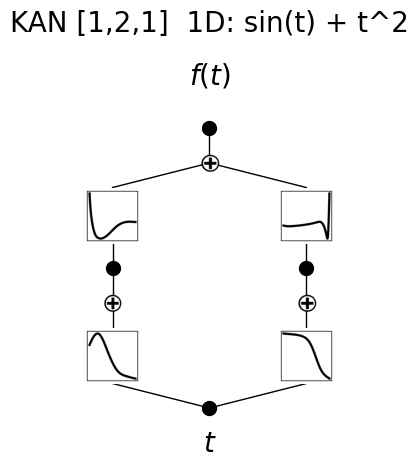

In [63]:
# előre-futtatás, hogy az aktivációk kiszámolódjanak
model(dataset['train_input'])

# graf ábra az aktivációs függvényekkel
model.plot(
    beta=100,              # nagy beta -> csak erős kapcsolatok látszanak
    in_vars=[r'$t$'],      # bemenet neve
    out_vars=[r'$f(t)$'],  # kimenet neve
    title='KAN [1,2,1]  1D: sin(t) + t^2'
)


In [64]:
from kan import KAN, create_dataset
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def f(x):
    t = x[:, [0]] * (2*torch.pi)
    return torch.sin(t) + t**2

dataset = create_dataset(f, n_var=1, device=device)

model = KAN(width=[1,2,1], grid=5, k=3, seed=0, device=device)
model.fit(dataset, opt="LBFGS", steps=30, lamb=0.01)


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.49e-01 | test_loss: 2.46e-01 | reg: 2.37e+01 | : 100%|█| 30/30 [00:06<00:00,  4.88it

saving model version 0.1


{'train_loss': [array(9.041362, dtype=float32),
  array(4.9010663, dtype=float32),
  array(4.491626, dtype=float32),
  array(3.8805554, dtype=float32),
  array(3.4615722, dtype=float32),
  array(1.9128214, dtype=float32),
  array(1.3418884, dtype=float32),
  array(1.2425841, dtype=float32),
  array(1.0043402, dtype=float32),
  array(0.6806874, dtype=float32),
  array(0.6181571, dtype=float32),
  array(0.6004887, dtype=float32),
  array(0.58978796, dtype=float32),
  array(0.5776049, dtype=float32),
  array(0.5643744, dtype=float32),
  array(0.51088506, dtype=float32),
  array(0.49237818, dtype=float32),
  array(0.44275948, dtype=float32),
  array(0.4317913, dtype=float32),
  array(0.41974008, dtype=float32),
  array(0.40112698, dtype=float32),
  array(0.38653, dtype=float32),
  array(0.3789489, dtype=float32),
  array(0.37344, dtype=float32),
  array(0.36982277, dtype=float32),
  array(0.38902673, dtype=float32),
  array(0.31562805, dtype=float32),
  array(0.26659128, dtype=float32),
  

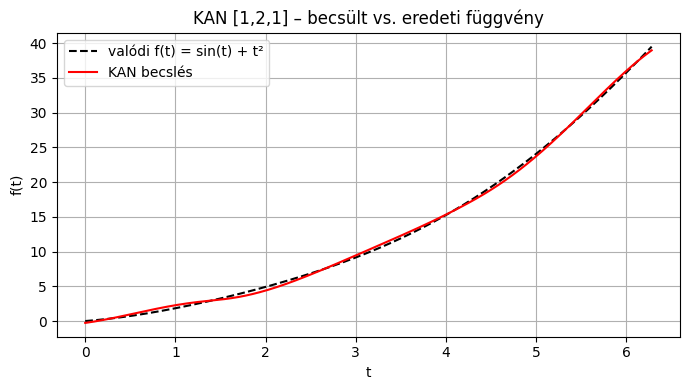

In [65]:
import numpy as np
import matplotlib.pyplot as plt

model.eval()  # inference mód

# sűrű rács az x ∈ [0,1] tartományon (KAN input)
x_plot = torch.linspace(0, 1, 400, device=device).unsqueeze(1)  # (400,1)

# ehhez tartozó "fizikai" t ∈ [0, 2π]
t_plot = x_plot * (2*torch.pi)

# valódi függvényértékek
y_true = torch.sin(t_plot) + t_plot**2

# modell előre-futtatás
with torch.no_grad():
    y_pred = model(x_plot)

# CPU-ra, numpy-ba
t_plot_np = t_plot.squeeze().cpu().numpy()
y_true_np = y_true.squeeze().cpu().numpy()
y_pred_np = y_pred.squeeze().cpu().numpy()

# ábra
plt.figure(figsize=(7,4))
plt.plot(t_plot_np, y_true_np, 'k--', label='valódi f(t) = sin(t) + t²')
plt.plot(t_plot_np, y_pred_np, 'r', label='KAN becslés')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('KAN [1,2,1] – becsült vs. eredeti függvény')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


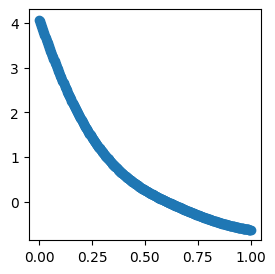

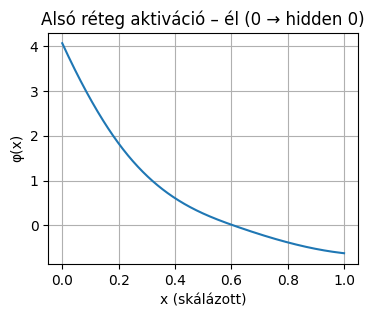

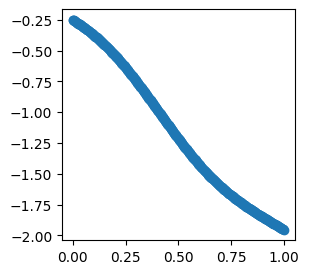

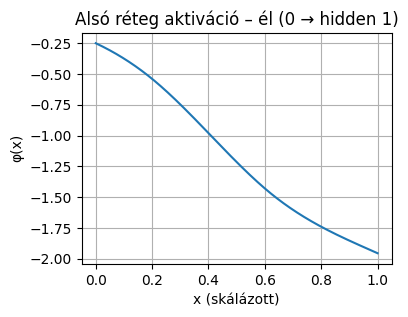

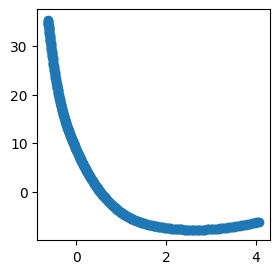

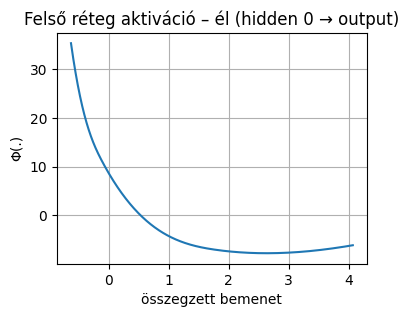

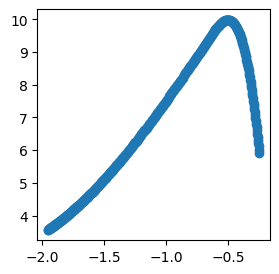

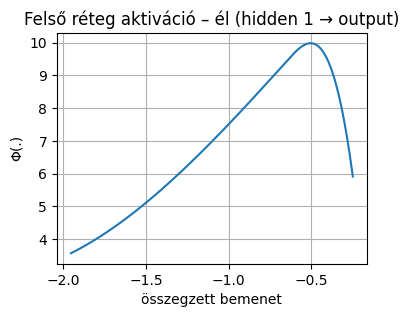

In [66]:
# alsó réteg 2 rejtett spline: (l=0, i=0, j=0) és (l=0, i=0, j=1)
for j in range(2):
    x_act, y_act = model.get_fun(l=0, i=0, j=j)
    plt.figure(figsize=(4,3))
    plt.plot(x_act, y_act)
    plt.title(f'Alsó réteg aktiváció – él (0 → hidden {j})')
    plt.xlabel('x (skálázott)')
    plt.ylabel('φ(x)')
    plt.grid(True)

# felső réteg splinjei (hidden → output) ugyanígy, l=1, i=0/1, j=0
for i in range(2):
    x_act, y_act = model.get_fun(l=1, i=i, j=0)
    plt.figure(figsize=(4,3))
    plt.plot(x_act, y_act)
    plt.title(f'Felső réteg aktiváció – él (hidden {i} → output)')
    plt.xlabel('összegzett bemenet')
    plt.ylabel('Φ(.)')
    plt.grid(True)

plt.show()


In [ ]:
def cubic_spline_from_coeffs(x, coeffs, knots):
    """
    Kubikus (degree=3) spline értéke:
    s(x) = Σ a_i B_i(x),
    ahol a_i = coeffs[i].
    """
    degree = 3
    n_basis = len(knots) - degree - 1
    coeffs = np.asarray(coeffs)
    assert len(coeffs) == n_basis

    y = np.zeros_like(x, dtype=float)
    for i in range(n_basis):
        y += coeffs[i] * bspline_basis(x, i, degree, knots)
    return y


def fit_cubic_spline_least_squares(x, y, knots):
    """
    Legkisebb négyzetes illesztés kubikus B-spline bázison.
    Megoldjuk: y ≈ B a   →   a = (B^T B)^(-1) B^T y
    """
    degree = 3
    n_basis = len(knots) - degree - 1

    # design mátrix: B_ij = B_i(x_j)
    B = np.zeros((len(x), n_basis))
    for i in range(n_basis):
        B[:, i] = bspline_basis(x, i, degree, knots)

    # normál egyenletek
    BTB = B.T @ B
    BTy = B.T @ y
    coeffs = np.linalg.solve(BTB, BTy)
    return coeffs


def demo_spline_fit(n_internal=5, noise=0.3):
    # "valódi" függvény + zajos adatok
    true_fun = lambda x: np.sin(2 * np.pi * x) + 0.5 * x
    rng = np.random.default_rng(0)
    x_data = rng.uniform(0.0, 1.0, size=200)
    y_data = true_fun(x_data) + noise * rng.normal(size=200)

    knots = even_knots(n_internal=n_internal, k0=0.0, kn=1.0)
    coeffs = fit_cubic_spline_least_squares(x_data, y_data, knots)

    x_grid = np.linspace(0.0, 1.0, 400)
    y_true = true_fun(x_grid)
    y_spline = cubic_spline_from_coeffs(x_grid, coeffs, knots)

    plt.figure(figsize=(7, 4))
    plt.scatter(x_data, y_data, s=10, alpha=0.5, label="adatpontok")
    plt.plot(x_grid, y_true, linestyle="--", label="valódi függvény")
    plt.plot(x_grid, y_spline, label="kubikus spline illesztés")
    for k in knots:
        plt.axvline(k, linestyle=":", linewidth=0.7)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Kubikus spline illesztés (belső knots = {n_internal})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


interact(
    demo_spline_fit,
    n_internal=IntSlider(value=5, min=2, max=15, step=1, description="belső knots"),
    noise=FloatSlider(value=0.3, min=0.0, max=1.0, step=0.05, description="zaj"),
);
